In [1]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


### Installing required libraries

In [ ]:
!pip install fastai
!pip install fastbook; # restart runtime to use the latest fastai version

In [3]:
# checking if latest version of fastai is installed
import fastai
print(fastai.__version__) #making new copy of notebook does not let you install / upgrade to latest version of fastai

2.5.3


In [4]:
# import libraries
from fastai.basics import *
from fastai.vision.all import * # if not working remove .all from fastai.vision.all
import fastbook
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc
import numpy as np
import pandas as pd
import os

In [5]:
# Change to folder location
os.chdir('/content/gdrive/MyDrive/kaggle/days-z-hp-yoga')

In [6]:
!ls

images			 sample_submission.gsheet   yoga_base_model.ipynb
models			 submission-base_model.csv  yoga_model_2.ipynb
resnet101_mixup.pkl	 submission.csv		    yoga_model_3.ipynb
resnet50_base_model.pkl  train.csv
sample_submission.csv	 yoga-1.ipynb


In [7]:
# Read in training dataframe
data = Path('images')
df = pd.read_csv('train.csv')
df = df.rename(columns={'image_id': 'fname', 'class_6': 'labels'})
df['labels'] = df['labels'].astype(str)
df.head()

,fname,labels
0,1daf45401342ac321c0aa5668f51d004.jpg,5
1,7e15c14f0b25766d0b7378f1d5328e99.jpg,4
2,1dc97053cf67cb8e51c983abb0021083.jpg,4
3,0ceaf686d3b9c1db537fed12b568670d.jpg,1
4,73adbf71f0adcf89c94339f6a6a92b61.jpg,0


* later divide the dataframe separately by class and put 70-30 train-val split
* check the methods by fastai for making validation set
* use this dataset too https://sites.google.com/view/yoga-82/





### Create dataloader and check some of the images as samples.

In [8]:
# Create dataloader
def get_x(r): return data/'train_images'/r['fname']
def get_y(r): return r['labels'] # these labels should be string otherwise error in mapping to 1-hot encoding
dblock = DataBlock(blocks=(ImageBlock, CategoryBlock),
                   splitter=RandomSplitter(),
                   item_tfms=Resize(460), 
                   batch_tfms=aug_transforms(size=224, min_scale=0.75),
                   get_x = get_x, 
                   get_y = get_y)

In [9]:
dsets = dblock.datasets(df)

In [10]:
dsets.train[0]

(PILImage mode=RGB size=400x300, TensorCategory(4))

In [11]:
dsets.valid[0]

(PILImage mode=RGB size=500x434, TensorCategory(2))

In [12]:
# now use dataloaders
dls = dblock.dataloaders(df)

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1051: UserWarning: torch.solve is deprecated in favor of torch.linalg.solveand will be removed in a future PyTorch release.
torch.linalg.solve has its arguments reversed and does not return the LU factorization.
To get the LU factorization see torch.lu, which can be used with torch.lu_solve or torch.lu_unpack.
X = torch.solve(B, A).solution
should be replaced with
X = torch.linalg.solve(A, B) (Triggered internally at  ../aten/src/ATen/native/BatchLinearAlgebra.cpp:766.)
  ret = func(*args, **kwargs)


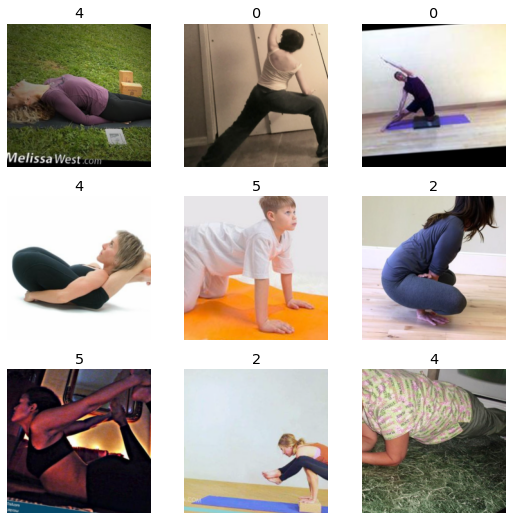

In [13]:
dls.show_batch()

#### Use pretrained-model (Resnet50) and train

In [14]:
learn = cnn_learner(dls, resnet50, metrics=F1Score(average='micro')) # change average='binary'
learn.fine_tune(3, base_lr=3e-3, freeze_epochs=4)

epoch,train_loss,valid_loss,f1_score,time
0,2.263653,1.345636,0.540254,00:18
1,1.794865,1.394100,0.603814,00:18
2,1.490791,1.270799,0.633475,00:19
3,1.284027,1.143896,0.652542,00:18


epoch,train_loss,valid_loss,f1_score,time
0,0.756701,0.997521,0.716102,00:19
1,0.633922,0.909376,0.745763,00:19
2,0.440660,0.795236,0.769068,00:20


SuggestedLRs(valley=5.248074739938602e-05)

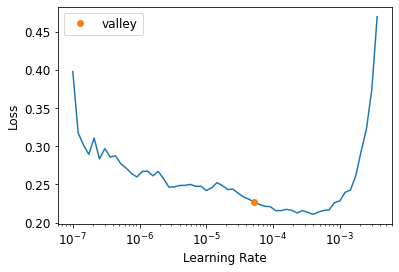

In [15]:
# find optimal learning rate
learn.lr_find()

In [16]:
learn.fine_tune(10, base_lr=3e-4, freeze_epochs=4, wd=0.1, moms=(0.9, 0.95, 0.99))

epoch,train_loss,valid_loss,f1_score,time
0,0.245769,0.765825,0.783898,00:19
1,0.224008,0.726545,0.783898,00:19
2,0.227985,0.699481,0.798729,00:19
3,0.210657,0.707173,0.798729,00:18


epoch,train_loss,valid_loss,f1_score,time
0,0.171210,0.710125,0.809322,00:19
1,0.158568,0.690290,0.807203,00:19
2,0.139353,0.682312,0.811441,00:19
3,0.136809,0.689702,0.813559,00:19
4,0.127978,0.675919,0.817797,00:19
5,0.115807,0.691327,0.811441,00:19
6,0.101621,0.680977,0.809322,00:19
7,0.094903,0.676492,0.809322,00:19
8,0.089986,0.671919,0.809322,00:20
9,0.082871,0.665439,0.815678,00:19


In [17]:
learn.fine_tune(30, 3e-4, wd=0.1, moms=(0.9, 0.95, 0.99))

epoch,train_loss,valid_loss,f1_score,time
0,0.082118,0.682705,0.815678,00:18


epoch,train_loss,valid_loss,f1_score,time
0,0.080583,0.660143,0.813559,00:19
1,0.073500,0.665098,0.811441,00:19
2,0.076252,0.668255,0.813559,00:19
3,0.066076,0.653043,0.813559,00:18
4,0.058269,0.634962,0.822034,00:20
5,0.056636,0.658216,0.822034,00:18
6,0.056289,0.649292,0.822034,00:18
7,0.054499,0.647652,0.817797,00:18
8,0.052972,0.670766,0.824153,00:20
9,0.052072,0.633248,0.815678,00:19


In [19]:
learn.fine_tune(30, 3e-4, wd=0.1, moms=(0.9, 0.95, 0.99))

epoch,train_loss,valid_loss,f1_score,time
0,0.071296,0.810382,0.807203,00:17


epoch,train_loss,valid_loss,f1_score,time
0,0.059964,0.749293,0.817797,00:19
1,0.053090,0.701581,0.826271,00:18
2,0.041733,0.661945,0.830508,00:18
3,0.039244,0.641382,0.843220,00:18
4,0.031092,0.638152,0.836864,00:19
5,0.027559,0.639266,0.834746,00:19
6,0.022858,0.613041,0.832627,00:18
7,0.018106,0.604416,0.851695,00:18
8,0.016174,0.614785,0.847458,00:19
9,0.015388,0.633227,0.830508,00:19


In [20]:
learn.fine_tune(10, 3e-5, wd=0.1, moms=(0.9, 0.95, 0.99))

epoch,train_loss,valid_loss,f1_score,time
0,0.008163,0.629768,0.847458,00:18


epoch,train_loss,valid_loss,f1_score,time
0,0.004491,0.612349,0.851695,00:19
1,0.008062,0.615537,0.851695,00:18
2,0.010016,0.620612,0.853814,00:18
3,0.009309,0.613289,0.851695,00:19
4,0.007823,0.611524,0.843220,00:19
5,0.007274,0.619572,0.849576,00:19
6,0.006432,0.625321,0.853814,00:20
7,0.006790,0.605782,0.851695,00:18
8,0.005745,0.629711,0.847458,00:19
9,0.005220,0.622198,0.851695,00:18


#### Saving model weights and doing prediction on test set.

In [23]:
learn.export('resnet50_base_model.pkl')

In [ ]:
# Load saved weights
learn = load_learner('resnet50_base_model.pkl')

In [24]:
# Get predictions on test set
test_dl = dls.test_dl(get_image_files(data/'test_images'))
preds, y = learn.get_preds(dl=test_dl)

In [25]:
# Arranging predictions in the submission format
pred_ls = [np.argmax(i) for i in preds]
pred_ls = [int(i) for i in pred_ls]

fnames = test_dl.items
fnames = [i.as_posix() for i in fnames]
test_names = [i.split("/")[-1] for i in fnames]

pred_df = pd.DataFrame.from_dict({
    "image_id" : test_names,
    "class_6" : pred_ls
})
pred_df.to_csv("./submission.csv", index=False)